Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best model accuracy: 0.9066666666666666


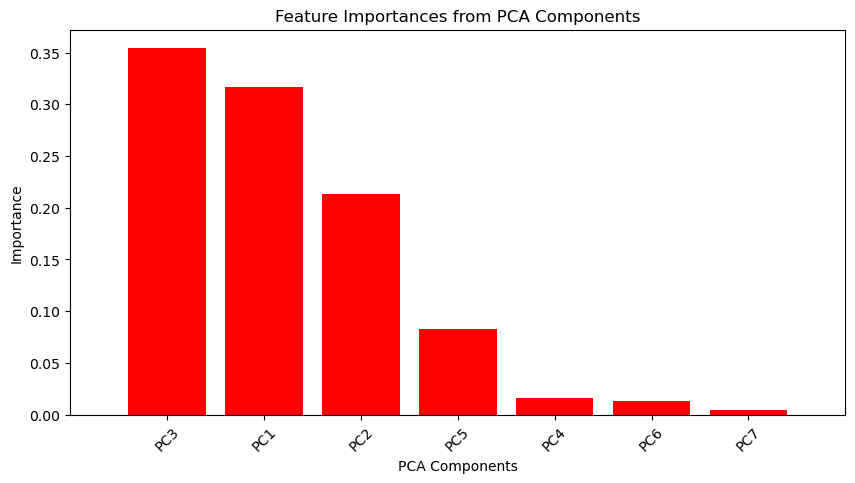

{'PC1': 'Age', 'PC2': 'Daily Steps', 'PC3': 'Gender', 'PC4': 'Heart Rate', 'PC5': 'Age', 'PC6': 'Sleep Duration', 'PC7': 'Stress Level'}


In [9]:
# Decision Tree Project 3
# Sleep health and lifestyle
# PROBLEM STATEMENT: To identify the risk of sleep disorders from routine health and lifestyle data.
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Load the dataset
df = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")

# Encode categorical variables
encoder = LabelEncoder()
df['Sleep Disorder'] = encoder.fit_transform(df['Sleep Disorder'])
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

# Impute missing values
imputer = SimpleImputer(strategy='mean')
df[['Age', 'Sleep Duration', 'Stress Level', 'Daily Steps', 'Heart Rate', 'Gender', 'Physical Activity Level']] = imputer.fit_transform(
    df[['Age', 'Sleep Duration', 'Stress Level', 'Daily Steps', 'Heart Rate', 'Gender', 'Physical Activity Level']]
)

# Create interaction term
df['Age_Activity_Interaction'] = df['Age'] * df['Physical Activity Level']

# Define features and target
features = df[['Age', 'Sleep Duration', 'Stress Level', 'Daily Steps', 'Heart Rate', 'Physical Activity Level', 'Age_Activity_Interaction', 'Gender']]
target = df['Sleep Disorder']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define the PCA and classifier in a pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),  
    ('pca', PCA(n_components=7)),  
    ('clf', DecisionTreeClassifier(random_state=42))
])

# Set up a param_grid for GridSearchCV
param_grid = {
    'clf__max_depth': [3, 5, 7, 10],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Evaluation
y_pred_best = best_model.predict(X_test)
best_accuracy = accuracy_score(y_test, y_pred_best)
print("Best model accuracy:", best_accuracy)

# Feature Importance Visualization adapted for PCA
importances = best_model.named_steps['clf'].feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 5))
plt.title('Feature Importances from PCA Components')
plt.bar(range(7), importances[indices], color="r", align="center")
plt.xticks(range(7), ["PC" + str(i+1) for i in indices], rotation=45)
plt.xlim([-1, 7])
plt.xlabel('PCA Components')
plt.ylabel('Importance')
plt.show()

# Access the PCA object
pca = grid_search.best_estimator_.named_steps['pca']

# Access the components
loadings = pca.components_

# Find the index of the feature that has the largest absolute coefficient
most_influential_feature_per_component = np.argmax(np.abs(loadings), axis=1)

# Get the names of these features
feature_names = features.columns
most_influential_names = [feature_names[idx] for idx in most_influential_feature_per_component]

# Create a mapping of principal component to the name of the most influential feature
pc_to_feature_mapping = {f'PC{i+1}': name for i, name in enumerate(most_influential_names)}

print(pc_to_feature_mapping)


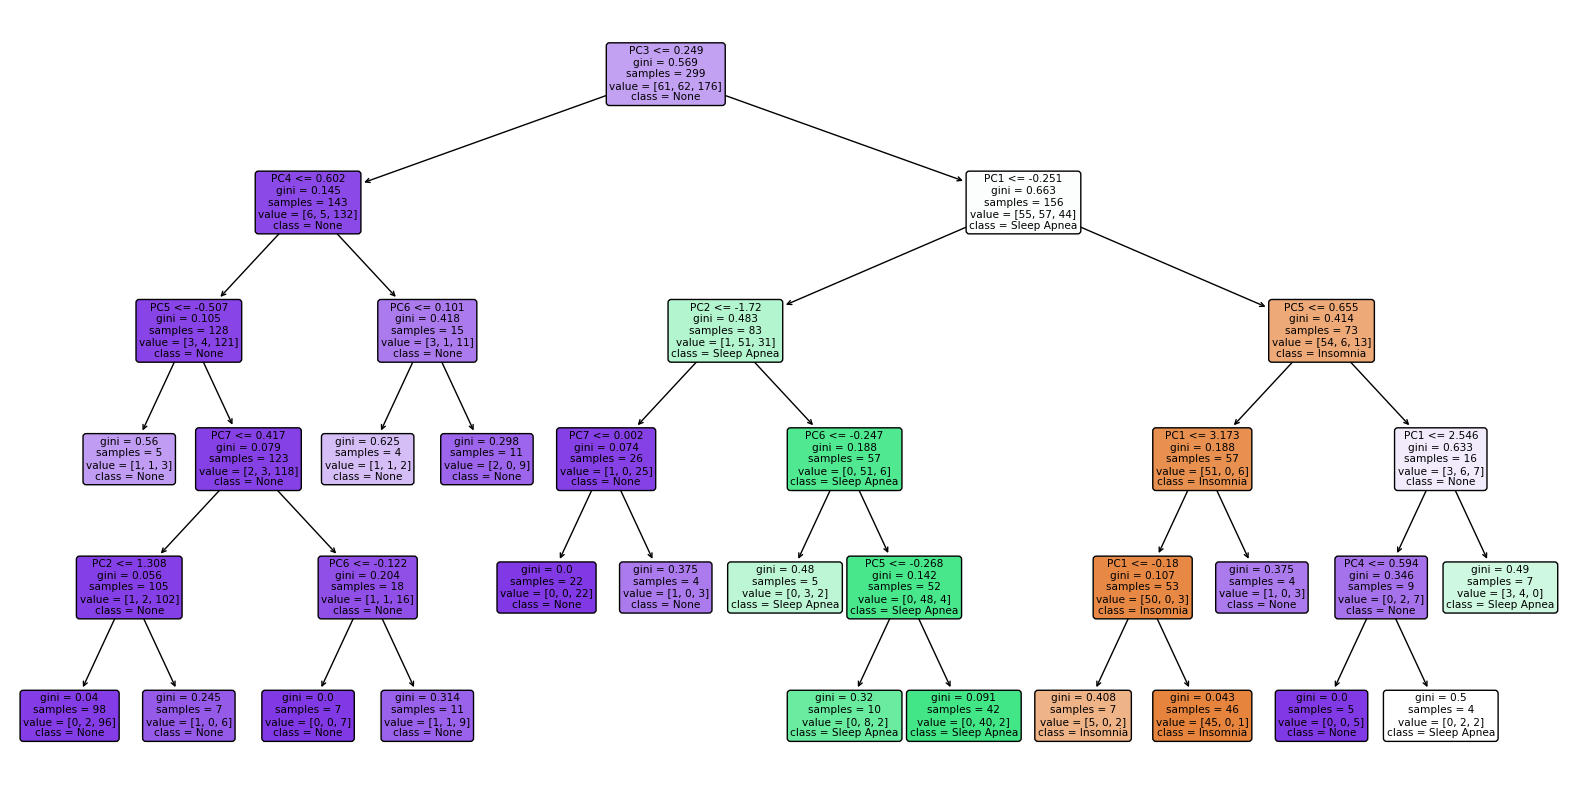

In [10]:
# Visual for decision tree
from sklearn.tree import plot_tree

# Extract the decision tree model from the pipeline
decision_tree_model = best_model.named_steps['clf']

pca_features = ['PC' + str(i+1) for i in range(grid_search.best_estimator_.named_steps['pca'].n_components_)]

plt.figure(figsize=(20, 10))
plot_tree(decision_tree_model,
          filled=True,
          rounded=True,
          class_names=['Insomnia', 'Sleep Apnea', 'None'],
          feature_names=pca_features)
plt.show()
